# Learning Truncation Sets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
import numpy as np

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### The Model
We first define the Neural Net that we will use to approximate the truncation set.
We will use a small ReLu Network for this application.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 50)
        self.fc7 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = 1. + torch.exp(self.fc7(x))
        return x

### Generating Truncated Samples
Here we define different truncation sets to test.  All of them are non-convex.

In [4]:
def set1(x):
    return int((x[1]**2 + x[0]**2) > 1/2)

def horseshoe_dot(x):
    return int((x[0] > 0 and x[0]**2 + x[1]**2 > 1 and x[0]**2 + x[1]**2 < 2) or ((x[0] - 1/2)**2 + (x[1] - 0)**2 < 1/6))

def horseshoe(x):
    return int(x[0] > 0 and x[0]**2 + x[1]**2 > 1 and x[0]**2 + x[1]**2 < 2)

def triangle(x):
    triangle = x[1]>=0 and x[1] <= +x[0] + 1 and x[1] <= 1- x[0]
    dot = (x[0]/2)**2 + (x[1]-0.52)**2 <= 0.02
    return int( triangle and (not dot) )

def truncated_samples(mean, cov, set, n):
    return np.array([truncated_sample(mean, cov, set) for x in range(1,n)])

def truncated_sample(mean, cov, set):
    while True:
        x = np.random.multivariate_normal(mean,cov)
        if set(x):
            break
    return x

We next generate truncated samples using the horseshoe_dot and the triangle truncation functions.

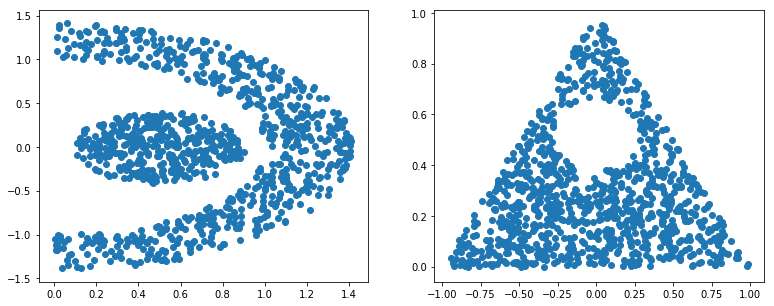

In [5]:
horseshoe_dot_data = truncated_samples([0,0], [[1,0],[0,1]], horseshoe_dot, 1000)

triangle_data = truncated_samples([0,0], [[1,0],[0,1]], triangle, 1000)

IPython.display.clear_output()
fig, axes = plt.subplots(1, 2, figsize=(13,5))
ax1, ax2 = axes.ravel()
x,y = horseshoe_dot_data.T
ax1.scatter(x, y)
x,y = triangle_data.T
ax2.scatter(x,y)
plt.show()

We now define the Dataloaders and hyperparameters.

In [6]:
integ_n = 10000
test_n = 10000
trunc_n = 40000
true_set = horseshoe_dot
# true_set = triangle
device = "cuda"
lr = 0.005
momentum = 0.5

trunc_data = truncated_samples([0,0], [[1,0],[0,1]], true_set, trunc_n)
train_data = torch.tensor(trunc_data,dtype=torch.float)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

# A standard 2D normal.
m = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

integral_data = m.sample((integ_n,))
integral_loader = torch.utils.data.DataLoader(integral_data, batch_size=2000, shuffle=True)

gaussian_points = m.sample((test_n,))
gaussian_labeled = torch.tensor([bool(true_set(x.numpy())) for x in gaussian_points])

test_data = torch.utils.data.TensorDataset(gaussian_points, gaussian_labeled)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

### Training Function
We define the training function according to the paper.

In [7]:
def train(model):
    model.train()
    for batch_idx, datax in enumerate(train_loader):
        datax = datax.to(device)
        datay = next(iter(integral_loader))
        datay = datay.to(device)

        optimizer.zero_grad()
        outx = model(datax)
        outy = model(datay)
        loss1 =  torch.mean(torch.log(outx))
        loss2 = torch.log(torch.mean(outy))
        loss = -loss1 + loss2
        loss.backward()
        optimizer.step()
    return(loss.item())

### Evaluation
Here we define different test functions to test our trained model.
To evaluate our model we use root mean squared error of our model and the zero-one loss (symmetric difference).

#### Root Mean Squared Error
If we denote by $A(x)$ our neural net and $S(x)$ the true $0-1$ indicator, the root mean squared error is equal to
$$
\sqrt{ \boldsymbol{\mathrm{E}}_{x \sim \mathcal{N}_0}\left(A(x) - S(x) \right)^2 }
\approx \sqrt{ \sum_{i=1}^N \left(A(x_i) - S(x_i) \right)^2},
$$
where we denote by $\mathcal{N}_0$ the standard normal
and we assume that $x_1,\ldots, x_N$ are independent samples from $\mathcal{N}_0$.
However, since we can only approximate $S(x)$ up to a scalar multiple, before we compute the root mean squared
error, we need to multiply $A(x)$ with an appropriate constant.  This constant is computed by the function opt_scale below. For this constant $a$ we choose the minimizer of $\sum_{i=1}^N (A(x_i) - a\ S(x_i))^2$,
namely 
$$
a = \frac{\sum_{i=1}^N A(x_i) S(x_i)}{\sum_{i=1}^N S(x_i) S(x_i)}
$$


In [8]:
def opt_scale(model, test_loader):
    model.eval()
    num = 0.
    denum = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device).float()
            outp = model(data).reshape(-1)
            num += torch.dot(outp, target).item()
            denum += torch.dot(outp, outp).item()
    return num/denum

def test_root_mse(model):
    model.eval()
    loss= 0.
    with torch.no_grad():
        a = opt_scale(model, test_loader)
        for data, target in test_loader:
            data = data.to(device)
            outp = a * model(data).reshape(-1)
            target = target.to(device).float()
            loss += torch.sum((outp-target)**2).item()
    return((loss/len(test_loader.dataset))**(0.5))

#### Zero-One (Symmetric Difference)

Evaluating our model using the zero-one loss is more straightforward.
We simply need to decide on a threshold to round the output of the neural network $A(x)$ to be either
$0$ or $1$.  For this threshold we simply use its average output on the data used to estimate the integral.
We denote by $t$ this threshold and define the rounded version of our Neural Net $R(x) = 0$ if $A(x)< t$ and $R(x) = 1$ otherwise. The estimate for the symmetric difference is now simply
$$
\sum_{i=1}^N \boldsymbol{1}( R(x_i) \neq S(x_i)),
$$
where $\boldsymbol{1}(\cdot)$ is the zero-one characteristic function.

In [9]:
def avg(model, data_loader):
    model.eval()
    total = 0.
    
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            outp = model(data)
            total += torch.sum(outp).item()
            
    return(total/len(data_loader.dataset))

def test_zero_one(model):
    model.eval()
    loss= 0.
    filtered = []
    with torch.no_grad():
        s = avg(model, integral_loader)
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outp = model(data).reshape(-1)
            outp = outp > s
            loss += outp.eq(target).sum().item()
            filtered_batch = (data * outp.float().view(len(outp), 1)).tolist()
            filtered_batch = [x for x in filtered_batch if x != [0,0] ]
            filtered = filtered + filtered_batch
    return(1-loss/len(test_loader.dataset), filtered)

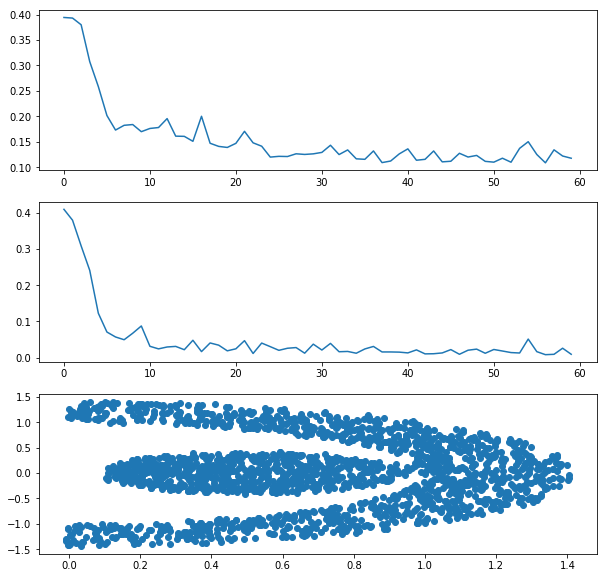

Epoch 60
Train Loss:    -1.597441
Test RMSE:     0.118049
Test Zero-One: 0.009500


In [10]:
epochs = 60
rmse_l = []
zero_one_l = []

for epoch in range(1, epochs + 1):
        train_loss = train(model)
        test_rmse = test_root_mse(model)
        test_01, filtered = test_zero_one(model)
        rmse_l.append(test_rmse)
        zero_one_l.append(test_01)
        IPython.display.clear_output()
        fig, axes = plt.subplots(3, figsize=(10,10))
        ax1, ax2, ax3 = axes.ravel()
        ax1.plot(rmse_l)
        ax2.plot(zero_one_l)
        x,y = zip(*filtered)
        ax3.scatter(x,y )
        plt.show()
        print("Epoch {:d}".format(epoch))
        print("Train Loss:    {:f}".format(train_loss))
        print("Test RMSE:     {:f}".format(test_rmse))
        print("Test Zero-One: {:f}".format(test_01))